In [2]:
from hydra import initialize, compose
import json
from rdkit import Chem
from pathlib import Path
from ergochem.draw import draw_reaction, draw_molecule
from IPython.display import SVG
import pandas as pd
import ast
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
with initialize(version_base=None, config_path="./conf/filepaths"):
    filepaths = compose(config_name="filepaths")

In [4]:
entries = {}
for i in range(0, 11):
    with open(Path(filepaths.raw_mcsa) / f"entries_{i}.json", "r") as f:
        entries = {**entries, **json.load(f)}

mech_ct = 0
detailed_ct = 0
for id, entry in entries.items():
    mechanisms = entry['reaction']['mechanisms']
    if mechanisms is None:
        continue

    for mech in mechanisms:
        mech_ct += 1
        if mech['is_detailed']:
            detailed_ct += 1

print(f"Total number of mechanisms: {mech_ct}")
print(f"Number of detailed mechanisms: {detailed_ct} ({detailed_ct/mech_ct*100:.2f}%)")
print(f"Total number of entries: {len(entries)}")


Total number of mechanisms: 1166
Number of detailed mechanisms: 887 (76.07%)
Total number of entries: 1003


In [5]:
mech_df = pd.read_csv(Path(filepaths.processed_data) / 'mcsa' / 'mech_labeled_reactions.csv', sep=",")
mech_df['mech_atoms'] = mech_df['mech_atoms'].apply(lambda x: ast.literal_eval(x))
print(f"{len(mech_df)/detailed_ct*100:.2f}% of detailed mechanisms have been processed")
mech_df.head(10)

70.80% of detailed mechanisms have been processed


entry_id  mechanism_id                                             smarts  \
0         1             1  [O:28]=[C:29]([O-:30])[CH:31]([NH3+:32])[CH2:3...   
1         2             2  [OH2:60].[CH:23]1([NH:36][C:38]([*:39])=[O:40]...   
2         2             1  [OH2:61].[CH:39]1([NH:52][C:54]([*:55])=[O:56]...   
3         4             2      [Cu+2:75].[O:57]=[N:58][OH:59]>>O.[N]=O.[Cu+]   
4         4             1      [Cu+2:65].[O:46]=[N:47][OH:48]>>O.[N]=O.[Cu+]   
5         6             1  [NH3+:76][CH:77]([CH2:78][CH2:79][C:80](=[O:81...   
6         7             2  [n:26]1([CH:28]2[O:32][CH:37]([CH2:41][O:43][P...   
7         7             1  [n:26]1([CH:28]2[O:32][CH:37]([CH2:41][O:43][P...   
8         7             3  [n:26]1([CH:28]2[O:32][CH:37]([CH2:41][O:43][P...   
9         8             2  [n:39]1[c:40]([C:45]([O-:46])=[O:49])[c:41]([C...   

                                          mech_atoms  \
0                                 [[28, 29, 30, 31]]   
1                               [[60], [24, 25, 27]]   
2                               [[61], [40, 41, 43]]   
3                                 [[], [57, 58, 59]]   
4                               [[65], [46, 47, 48]]   
5                     [[115, 104], [33, 35, 37, 39]]   
6       [[52, 54, 56, 58], [76, 77, 80, 82, 81, 83]]   
7       [[52, 54, 56, 58], [76, 77, 80, 82, 81, 83]]   
8       [[52, 54, 56, 58], [76, 77, 80, 82, 81, 83]]   
9  [[39, 40, 45, 46], [18, 19, 31, 33, 35, 38, 62...   

                                         enzyme_name uniprot_id        ec  
0                                 glutamate racemase     P56868   5.1.1.3  
1                           beta-lactamase (Class A)     P62593   3.5.2.6  
2                           beta-lactamase (Class A)     P62593   3.5.2.6  
3                    nitrite reductase (copper type)     P25006   1.7.2.1  
4                    nitrite reductase (copper type)     P25006   1.7.2.1  
5                    glutathione-disulfide reductase     P00390   1.8.1.7  
6                   isocitrate dehydrogenase (NADP+)     P08200  1.1.1.42  
7                   isocitrate dehydrogenase (NADP+)     P08200  1.1.1.42  
8                   isocitrate dehydrogenase (NADP+)     P08200  1.1.1.42  
9  nicotinate-nucleotide diphosphorylase (carboxy...     P9WJJ7  2.4.2.19

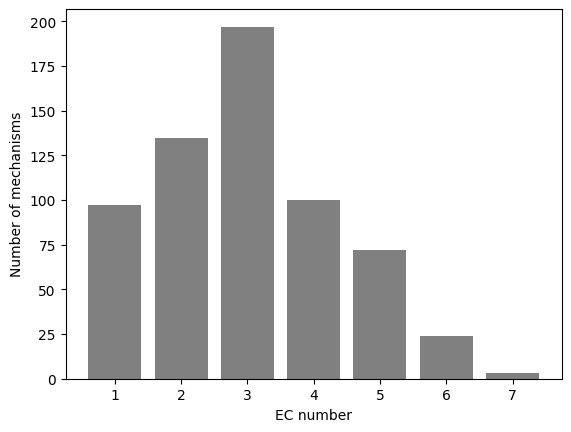

In [6]:
ecs = []
n_digits = 1
for eid in mech_df['entry_id']:
    ecs.append(entries[str(eid)]['reaction']['ec'])

ec_trunc = [elt[:n_digits] for elt in ecs]
ec_counts = Counter(ec_trunc)
ec_counts = sorted(ec_counts.items(), key=lambda x: x[0])

fig, ax = plt.subplots()
x = [i for i in range(len(ec_counts))]
ax.bar(x, [elt[1] for elt in ec_counts], color='gray')
ax.set_xticks(x)
ax.set_xticklabels([elt[0] for elt in ec_counts])
ax.set_xlabel('EC number')
ax.set_ylabel('Number of mechanisms')
plt.show()

In [7]:
def display_mech_labeled_rxn(entry_id: int, de_am: bool = True):
    sma2mol = lambda x : Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmarts(x)))

    # Get the reaction
    smarts = mech_df.loc[mech_df['entry_id'] == entry_id, 'smarts'].iloc[0]

    these_mechs = mech_df.loc[mech_df['entry_id'] == entry_id]
    for _, row in these_mechs.iterrows():
        print(f"Mechanism: #{row['mechanism_id']}")
        smarts = row['smarts']
        lhs = [sma2mol(elt) for elt in smarts.split('>>')[0].split('.')]
        mech_atom_map_nums = row['mech_atoms']

        # Get atoms involved in the reaction
        involved_atoms = []
        for ams, mol in zip(mech_atom_map_nums, lhs):
            involved_atoms.append([atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomMapNum() in ams])

        
        if de_am:
            for mol in lhs:
                for atom in mol.GetAtoms():
                    atom.SetAtomMapNum(0)

            smarts = '.'.join([Chem.MolToSmiles(mol) for mol in lhs]) + '>>' + smarts.split('>>')[1]
        
        # Display
        display(SVG(draw_reaction(smarts, sub_img_size=(150, 100))))
        for i, rct in enumerate(lhs):
            display(SVG(draw_molecule(rct, size=(300, 200), highlight_atoms=involved_atoms[i], draw_options={"addAtomIndices": False})))

In [8]:
# display_mech_labeled_rxn(5)

Mechanism: #1


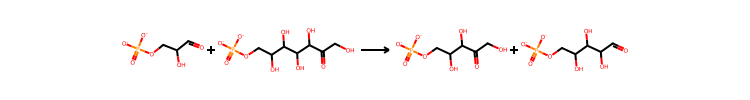

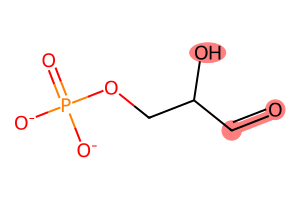

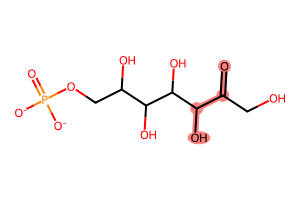

In [9]:
display_mech_labeled_rxn(219)

Mechanism: #2


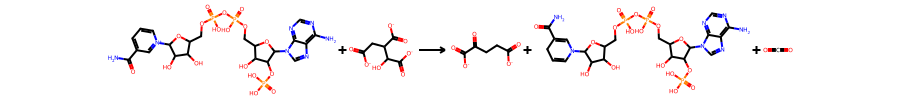

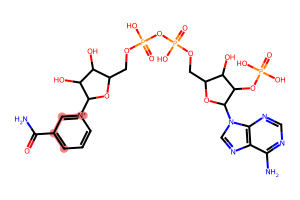

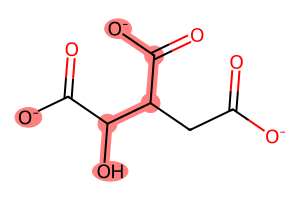

Mechanism: #1


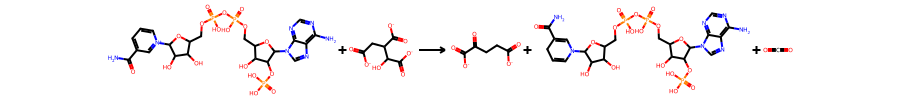

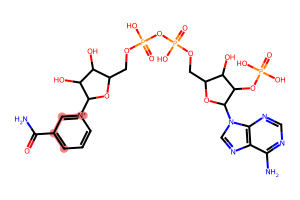

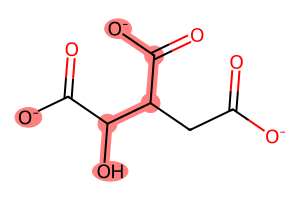

Mechanism: #3


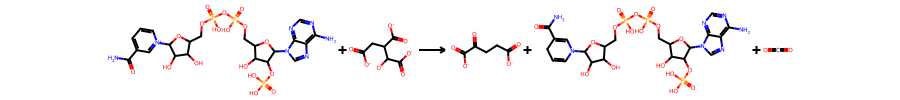

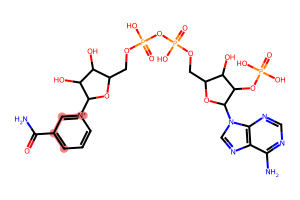

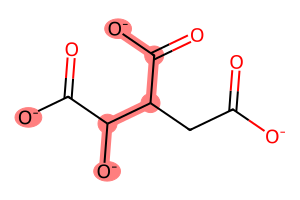

In [10]:
display_mech_labeled_rxn(7)

Mechanism: #2


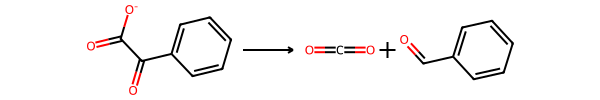

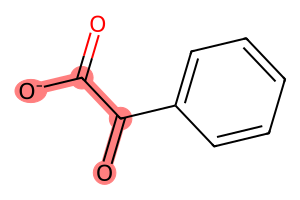

Mechanism: #3


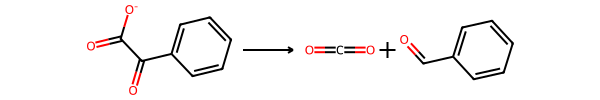

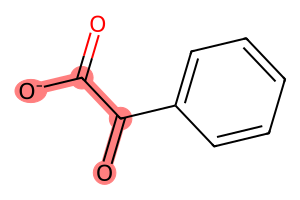

Mechanism: #1


[12:28:02] WARNING: not removing hydrogen atom without neighbors


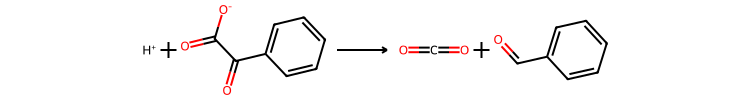

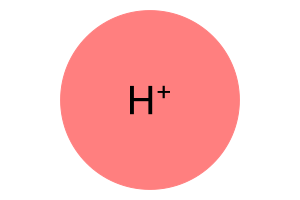

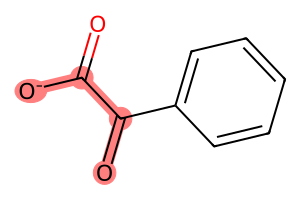

In [11]:
display_mech_labeled_rxn(220)

Mechanism: #1


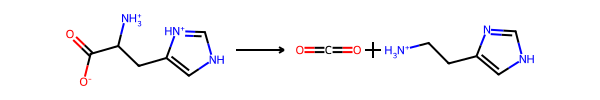

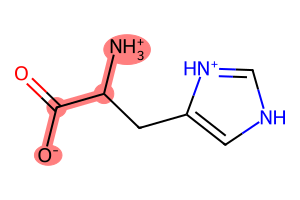

In [12]:
display_mech_labeled_rxn(49)

Mechanism: #1


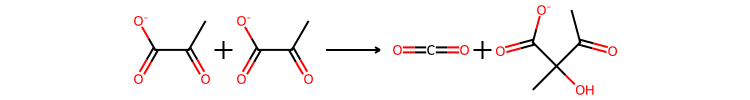

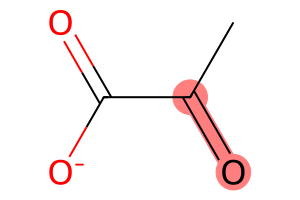

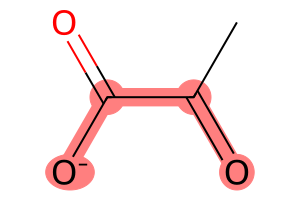

In [13]:
display_mech_labeled_rxn(722)

Mechanism: #1


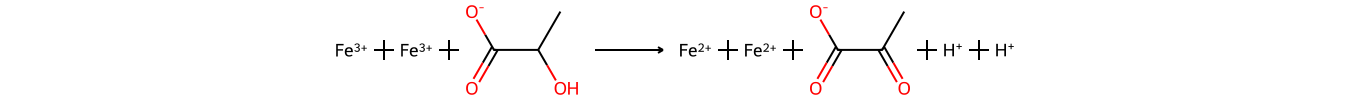

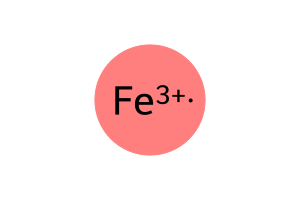

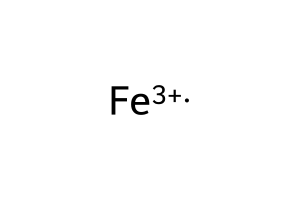

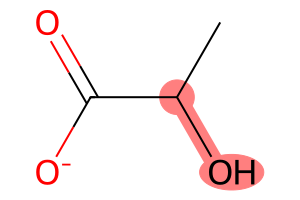

Mechanism: #2


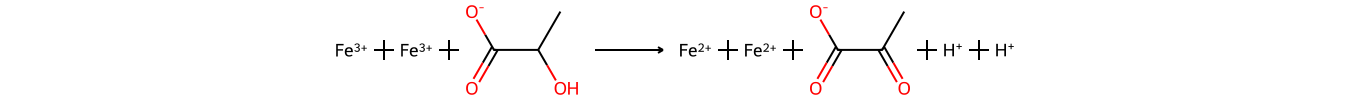

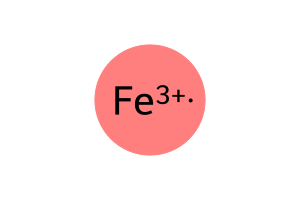

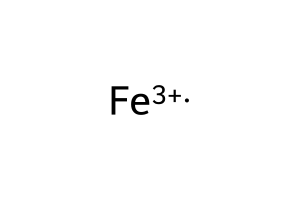

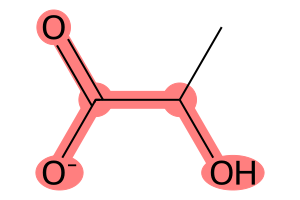

In [14]:
display_mech_labeled_rxn(102)